In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
auth = pd.read_csv("../input/banfakenews/Authentic-48K.csv")
fake = pd.read_csv("../input/banfakenews/Fake-1K.csv")

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [4]:
df = pd.concat([auth[:fake.shape[0]*7], fake])
df = df.sample(frac=1).reset_index(drop=True)
len(df)

10392

In [5]:
df = df.drop('domain', axis=1)
df = df.drop('date', axis=1)
df = df.drop('category', axis=1)
df = df.drop('articleID', axis=1)

In [6]:
df['data'] = df['headline'] + ' ' + df['content']

In [7]:
df['class'] = df['label'].replace({0: 'fake', 1: 'true'})

In [8]:
df = df.drop('headline', axis=1)
df = df.drop('content', axis=1)
df = df.drop('label', axis=1)




In [9]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [10]:
df.dropna(inplace=True)
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [11]:
for column in df.columns:
    df[column] = df[column].str.slice(0, 100)

In [12]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [13]:
df_lengths = df.applymap(lambda x: len(str(x)))

# Display the DataFrame with string lengths
print(df_lengths)

       data  class
0       100      4
1       100      4
2       100      4
3       100      4
4       100      4
...     ...    ...
10387   100      4
10388   100      4
10389   100      4
10390   100      4
10391   100      4

[10392 rows x 2 columns]


In [14]:
text = df['data'].values.tolist()
label = df['class'].tolist()

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text , label, test_size=0.2, random_state=42)

In [16]:
pip install ktrain


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 42.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 52.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 43.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 34.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.38.0-py3-none-any.whl size=25319964 sha256=563d488d18

In [17]:

import ktrain
from ktrain import text
MODEL_NAME = 'sagorsarker/bangla-bert-base'
t = text.Transformer(MODEL_NAME, maxlen=500)

In [18]:
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)

preprocessing train...
language: bn
train sequence lengths:
	mean : 15
	95percentile : 18
	99percentile : 20


Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 15
	95percentile : 18
	99percentile : 19


In [19]:
model = t.get_classifier()

In [20]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)


In [21]:
history = learner.fit_onecycle(2e-5, 8)




begin training using onecycle policy with max lr of 2e-05...
Epoch 1/8
1386/1386 [==============================] - 659s 461ms/step - loss: 0.2439 - accuracy: 0.9077 - val_loss: 0.1767 - val_accuracy: 0.9317
Epoch 2/8
1386/1386 [==============================] - 633s 457ms/step - loss: 0.1276 - accuracy: 0.9532 - val_loss: 0.1454 - val_accuracy: 0.9423
Epoch 3/8
1386/1386 [==============================] - 633s 457ms/step - loss: 0.0607 - accuracy: 0.9806 - val_loss: 0.1384 - val_accuracy: 0.9481
Epoch 4/8
1386/1386 [==============================] - 633s 457ms/step - loss: 0.0398 - accuracy: 0.9851 - val_loss: 0.2109 - val_accuracy: 0.9461
Epoch 5/8
1386/1386 [==============================] - 634s 457ms/step - loss: 0.0309 - accuracy: 0.9905 - val_loss: 0.2100 - val_accuracy: 0.9524
Epoch 6/8
1386/1386 [==============================] - 633s 457ms/step - loss: 0.0111 - accuracy: 0.9954 - val_loss: 0.2050 - val_accuracy: 0.9490
Epoch 7/8
1386/1386 [==============================] - 

In [22]:
learner.validate(class_names=t.get_classes()) 


65/65 [==============================] - 8s 89ms/step
              precision    recall  f1-score   support

        fake       0.84      0.79      0.81       263
        true       0.97      0.98      0.97      1816

    accuracy                           0.95      2079
   macro avg       0.90      0.88      0.89      2079
weighted avg       0.95      0.95      0.95      2079



array([[ 208,   55],
       [  41, 1775]])

In [23]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend() 

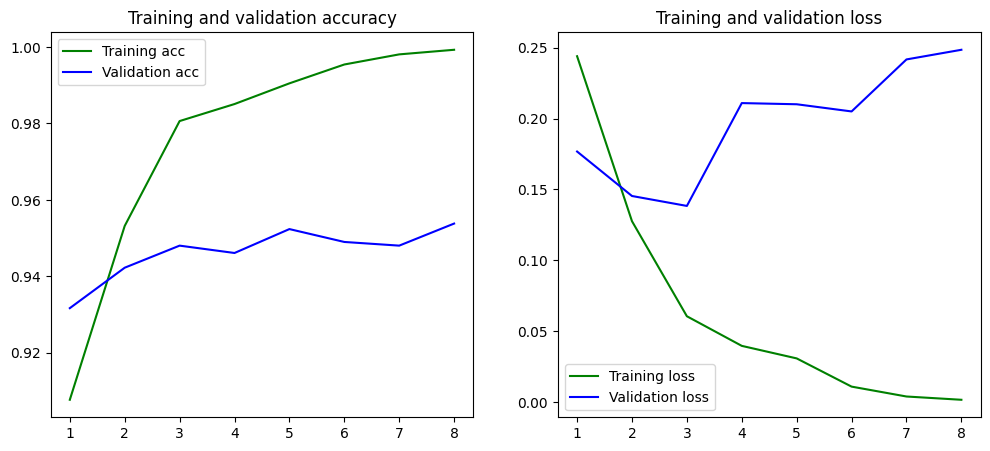

In [24]:
PlotGraph(history)